Service Level -> [0.5, 0.5, 0.58, 0.94, 0.95, 0.95]
Safety Stock->  [  0   0  50 344 176 188]
Total Cost->  6253
SE Safety Stock->  [190 162 196 190 162 174]
SE Total Cost->  3097


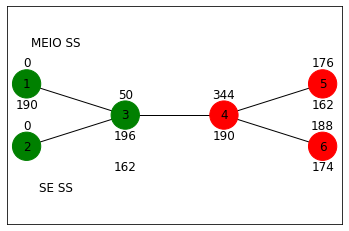

In [4]:
#data in months, lead time days, lead time variability included
%reset -f
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import norm
import math

import pandas as pd
import numpy as np
file_loc = "Stochastic_Hybrid_Input.xlsx"
df = pd.read_excel(file_loc, index_col=None)

LT = np.array(df['LEAD_TIME'])
Product_Cost = np.array(df['PRODUCT_COST'])
Holding_Cost = np.array(df['HOLDING_COST_%'])
Demand = np.array(df['DEMAND'])
Std_dev = np.array(df['STD_DEVIATION'])
LT_Std_dev=np.array(df['LT_STD_DEV'])
Q = np.array([750,500,1000,1000,2000,2000])
SLi = np.array(df['SERVICE_LEVEL_INITIAL'])
Backorder_Unit_Cost = (Product_Cost*Holding_Cost*SLi)/(1-SLi)
SL_Final_Node1 = df.iloc[4, 10]
SL_Final_Node2 = df.iloc[5, 10]


def opt(x):
    
    SL=np.array([x[0],x[1],x[2],x[3],SL_Final_Node1,SL_Final_Node2])
    k=norm.ppf(SL)
    ELT = np.zeros((6))
    ELT[0]=LT[0]
    ELT[1]=LT[1]
    ELT[2]=LT[2]+max((1-SL[0])*LT[0],(1-SL[1])*LT[1])
    for i in range(3,5):
        ELT[i]=LT[i]+(1-SL[i-1])*LT[i-1]
    ELT[5]=LT[5]+(1-SL[3])*LT[3]
    LF=norm.pdf(SL, loc=0, scale=1)-SL*(1-norm.cdf(SL, loc=0, scale=1))
    Exp_Backorder=Std_dev*LF*((ELT/30)**(1/2))
    Safety_Stock= k*(((ELT/30)*(Std_dev**2))+(LT_Std_dev*(ELT/30)*Demand)**2)**(1/2)
    Total_Cost= (Safety_Stock)*Product_Cost*Holding_Cost+Exp_Backorder*Backorder_Unit_Cost
    Cost=np.sum(Total_Cost)
    return Cost

bounds = [(.50, .99), (.50, .99), (.50, .99), (.50, .99)]

result = differential_evolution(opt, bounds)
result.x, result.fun
a=result.x
SL1 = np.array([a[0],a[1],a[2],a[3],SL_Final_Node1,SL_Final_Node2])
service_level = [np.round(x,2) for x in SL1]
print("Service Level ->",service_level)

#Recalculation for output

k=norm.ppf(SL1)
ELT = np.zeros((6))
ELT[0]=LT[0]
ELT[1]=LT[1]
ELT[2]=LT[2]+max((1-SL1[0])*LT[0],(1-SL1[1])*LT[1])
for i in range(3,5):
    ELT[i]=LT[i]+(1-SL1[i-1])*LT[i-1]
ELT[5]=LT[5]+(1-SL1[3])*LT[3]
LF=norm.pdf(SL1, loc=0, scale=1)-SL1*(1-norm.cdf(SL1, loc=0, scale=1))
Exp_Backorder=Std_dev*LF*((ELT/30)**(1/2))
Safety_Stock= k*(((ELT/30)*(Std_dev**2))+(LT_Std_dev*(ELT/30)*Demand)**2)**(1/2)
Total_Cost= (Safety_Stock)*Product_Cost*Holding_Cost+Exp_Backorder*Backorder_Unit_Cost
Cost=round(np.sum(Total_Cost))

safety_stock = np.array(Safety_Stock)
safety_stock=safety_stock.astype(int)
Cost=np.array(Cost)
Cost=Cost.astype(int)
print("Safety Stock-> ",safety_stock)
print("Total Cost-> ",Cost)
#print(Total_Cost)
#print(Exp_Backorder)
#print(ELT)
#print(Std_dev)

#single echelon calculation
k1=norm.ppf(SLi)
SE_Safety_Stock = np.zeros(6)
SE_Safety_Stock= k1*(((LT/30)*(Std_dev**2))+(LT_Std_dev*(LT/30)*Demand)**2)**(1/2)
SE_Total_Cost= (SE_Safety_Stock)*Product_Cost*Holding_Cost
SE_Cost=round(np.sum(SE_Total_Cost))
SE_Safety_Stock=SE_Safety_Stock.astype(int)
SE_Total_Cost=SE_Total_Cost.astype(int)
SE_Cost=SE_Cost.astype(int)
print("SE Safety Stock-> ",SE_Safety_Stock)
print("SE Total Cost-> ",SE_Cost)


#network graph display trial

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

MEIO_SS = safety_stock
SE_SS = SE_Safety_Stock

nxG=nx.Graph()

NxNodeList= [1,2,3,4,5,6]
nxG.add_nodes_from(NxNodeList)

NxEdgeList= [(1,3),(2,3),(3,4),(4,5),(4,6)]
nxG.add_edges_from(NxEdgeList)

pos = {1: [0,0.03],
       2: [0,-0.03],
       3: [1,0],
       4: [2,0],
       5: [3,.03],
       6: [3,-.03]}

color_map=[]
size_map=[]

for i in nxG.nodes:
    if MEIO_SS[i-1]<SE_SS[i-1]:
        color_map.append('green')
    else:
        color_map.append('red')

pos1 = {1: [0,.05],
        2: [0,-.01],
        3: [1,.02],
        4: [2,.02],
        5: [3,.05],
        6: [3,-.01]}

label1=dict(zip(NxNodeList,MEIO_SS))

pos2 = {1: [0,.01],
        2: [0,-.05],
        3: [1,-.02],
        4: [2,-.02],
        5: [3,.01],
        6: [3,-.05]}

label2=dict(zip(NxNodeList,SE_SS))
sizes=[800,800,800,800,800,800]

pos3={1:[0.3,0.07]}
label3={1:'MEIO SS'}

pos4={1:[0.3,-0.07]}
label4={1:'SE SS'}

nx.draw_networkx(nxG, pos, nodelist=NxNodeList,node_color=color_map,node_size=sizes)
nx.draw_networkx_labels(nxG, pos1, label1, font_size=12)
nx.draw_networkx_labels(nxG, pos2, label2, font_size=12)
nx.draw_networkx_labels(nxG, pos3, label3, font_size=12)
nx.draw_networkx_labels(nxG, pos4, label4, font_size=12)

plt.savefig("SSM network.png")